In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt
colors = sns.color_palette()
%matplotlib inline

In [3]:
data_path = '/disk/ru'
streams = pd.read_json(os.path.join(data_path, 'streams'), lines=True)
streams['timestamp'] = pd.to_datetime(streams['timestamp'], format='%Y-%m-%d %H:%M:%S')
streams.sort_values(by=['timestamp'], inplace=True)
streams.reset_index(inplace=True, drop=True)
streams['delta'] = streams.groupby(['user_id'])['timestamp'].diff().dt.total_seconds()

streams.head()

,device_type,length,os,timestamp,track_id,user_id,delta
0,desktop,254,Linux,2017-09-09,2318538f5412b3e87cf335fb667c0e7f121ae830,bab3607bf601e7e681012f206b62b4b39ee7023c,NaN
1,mobile,179,iOS,2017-09-09,dc1dd219d560a964281d777ad34a62af288a1de8,2622b170e9ddcb7d05946e914ad6fe61cee6ea63,NaN
2,mobile,242,Android,2017-09-09,d6aa6ac360c555ef96830404a0b66cc2a4d6fb8d,637d4c31a14e65cf77a6bd75a2aa605e8655b244,NaN
3,mobile,214,iOS,2017-09-09,c0dd8f4afbd640483b2746bc7287a52383e63b72,885085495b80cb431f149b3d82fb4bcc44ea7469,NaN
4,mobile,249,Android,2017-09-09,212eebd1e92303a5e0c43141561a724d3b47b549,5e94bc2ccd18805ba6b1747cc5d3260020425b00,NaN


# Exploration 

## Three kinds of user
1. Normal user: no fix actions
2. Type I potential fraud: listen huge number of tracks in 15 mins
3. Type II potentially fraud: listen huge number of tracks after a long time

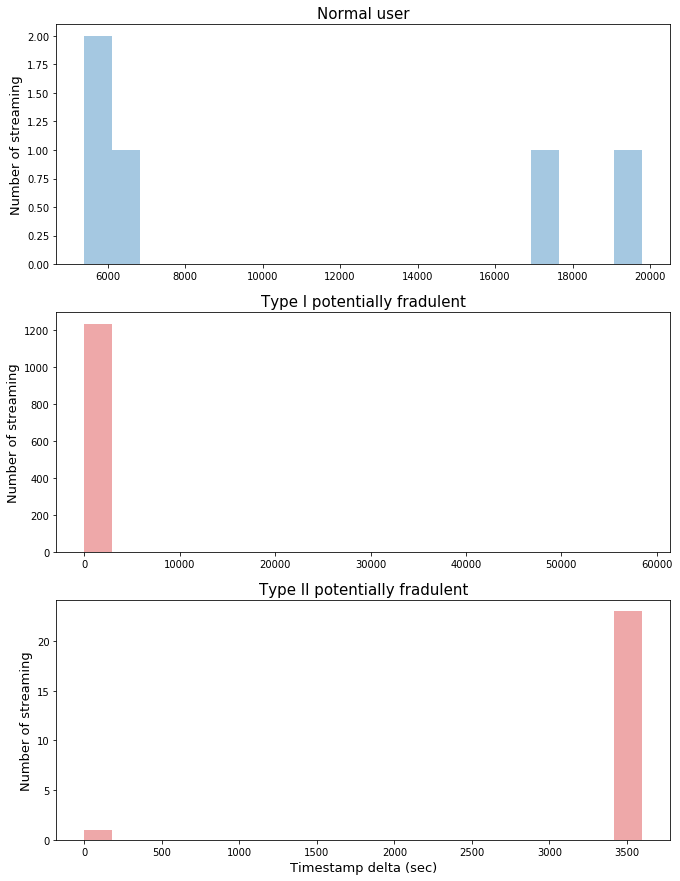

In [7]:
fig, axes = plt.subplots(nrows=3, figsize=(11, 15))
plt.subplot(3,1,1)
sns.distplot(streams['delta'].loc[streams['user_id']=='5b6d51824857416e5ae15792abd0103fd91618f1'].dropna(), 
             kde=False, bins=20)
plt.title('Normal user', fontsize=15)
plt.xlabel('', size=13)
plt.ylabel('Number of streaming', size=13)

plt.subplot(3,1,2)
sns.distplot(streams['delta'].loc[streams['user_id']=='c41f7f98ec5c0fdd81c23f2a43ad3d6e9b85cade'].dropna(), 
             kde=False, bins=20, color=colors[3])
plt.title('Type I potentially fraud', fontsize=15)
plt.xlabel('', size=13)
plt.ylabel('Number of streaming', size=13)

plt.subplot(3,1,3)
sns.distplot(np.append(streams['delta'].loc[streams['user_id']=='58d02c067e05aaa67404d3b6cb50233604b48b0f'].dropna().values, 0), 
             kde=False, bins=20, color=colors[3])
plt.title('Type II potentially fraud', fontsize=15)
plt.xlabel('Timestamp delta (sec)', size=13)
plt.ylabel('Number of streaming', size=13)

plt.show()

## Track legth & Number of play

In [57]:
track_dist = streams.groupby(['track_id'])['length'].agg({'time': len, 'mean_len': np.mean})

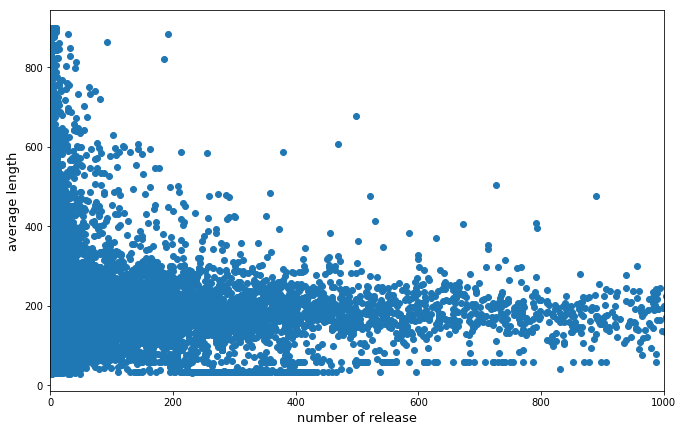

In [20]:
plt.figure(figsize=(11, 7))
plt.scatter(x=track_dist['time'], y=track_dist['mean_len'], color=colors[0])
plt.xlabel('number of play', size=13)
plt.ylabel('average length', size=13)
plt.xlim((0, 1000))
plt.show()

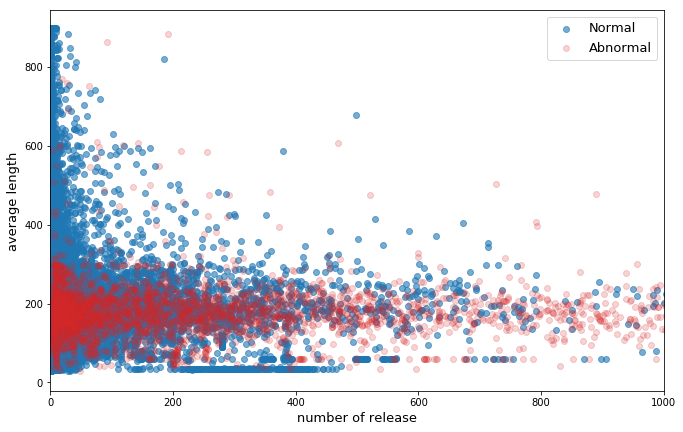

In [60]:
plt.figure(figsize=(11, 7))
plt.scatter(x=track_dist['time'].drop(fraud), y=track_dist['mean_len'].drop(fraud), color=colors[0], 
            alpha=.6, label='Normal')
plt.scatter(x=track_dist['time'].loc[fraud], y=track_dist['mean_len'].loc[fraud], color=colors[3], 
            alpha=.2, label='Abnormal')
plt.xlabel('play time', size=13)
plt.ylabel('average length', size=13)
plt.xlim((0, 1000))
plt.legend(prop={'size': 13})

plt.show()

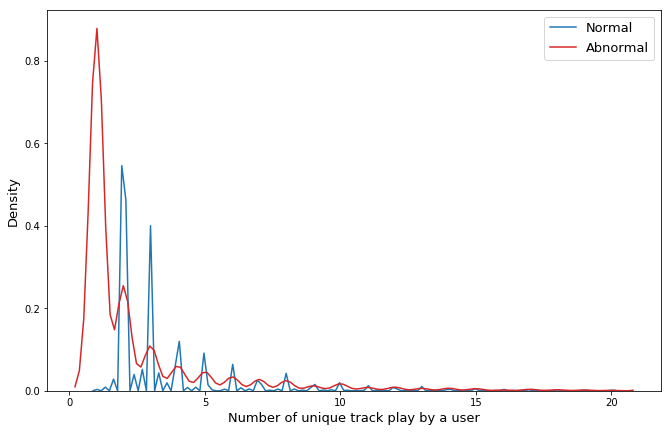

In [419]:
fraud = play_single.loc[play_single>3]
fraud.name = 'cnt'
fraud = fraud.reset_index()
fraud = fraud['user_id'].unique()

# Plot delta distribution
plt.figure(figsize=(11, 7))
sns.distplot(user_track.drop(fraud).loc[user_track<=20], hist=False, color=colors[0], label='Normal')
sns.distplot(user_track.loc[fraud].loc[user_track<=20], hist=False, color=colors[3], label='Abnormal')
plt.xlabel('Number of unique track play by a user', size=13)
plt.ylabel('Density', size=13)
plt.legend(prop={'size': 13})

plt.show()

In [12]:
# User mapping track
user_track = streams.groupby('user_id')['track_id'].nunique()

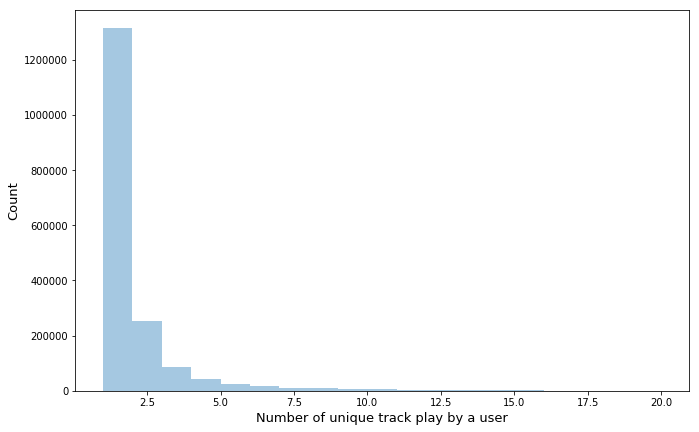

In [344]:
plt.figure(figsize=(11, 7))
sns.distplot(user_track.loc[user_track<=20], kde=False, bins=19)
plt.xlabel('Number of unique track play by a user', size=13)
plt.ylabel('Count', size=13)
plt.show()

# Abnormal Behavior User
the potentail botnet behavior

In [391]:
abnormal_user = []

# Abnormal Behavior Define 1: Cyclic
## Rules :  play over 3 times and have all same delta  

normal user behavior is rather random  
abnormal user behavior is rather fixed  
a. play tracks many times in same period  
b. play tracks in exactly same interval  
c. play tracks many times and keep playing

In [23]:
index = pd.date_range('2017-09-09 00:00:00', '2017-09-09 23:45:00', freq='15min')
data = pd.Series(0, index=index, name='tmp')
data = pd.concat([data, 
                  streams['timestamp'].loc[streams['user_id']=='5b6d51824857416e5ae15792abd0103fd91618f1'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='745cdb4f943954c7cf4bcbe588731b3af4548950'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='aad4e439093860edfbe9b3dc8c68963a712b37b0'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='d31bd3a4461ed83828f18ae59537fd6264a5eec0'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='58d02c067e05aaa67404d3b6cb50233604b48b0f'].value_counts(), 
                  streams['timestamp'].loc[streams['user_id']=='b6d1cb74cc340fc889756289296db845323e0b46'].value_counts(), 
                 ], axis=1)
data.drop(['tmp'], axis=1, inplace=True)
data.columns = ['normal_user_1', 'normal_user_2', 'normal_user_3', 
                'abnormal_user_1', 'abnormal_user_2', 'abnormal_user_3']

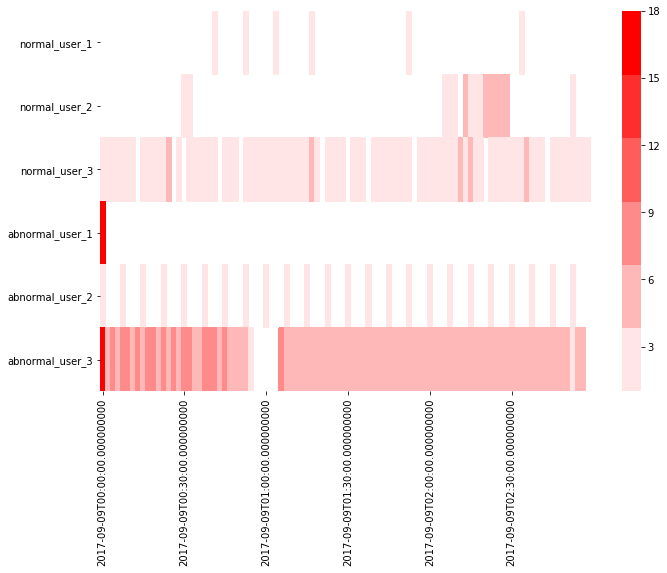

In [9]:
cmap = sns.light_palette("red")

plt.figure(figsize=(11, 7))
sns.heatmap(data.T, cmap=cmap)
plt.locator_params(axis='x', nbins=6)
plt.show()

In [310]:
user_play = streams.groupby('user_id').size()
user_delta = streams.groupby('user_id')['delta'].std()

In [376]:
# outlier 
cyclic_userId = streams.loc[
    streams['user_id'].isin(user_play[user_play>3].index 
                            & user_delta[user_delta==0].index)]['user_id'].unique()

In [401]:
abnormal_user = np.append(abnormal_user, cyclic_userId)

In [348]:
cyclic_userId.shape[0]/streams['user_id'].unique().shape[0]

0.005281481365465981

# Abnomal Behavior 2:  play same track 
## Rules :  user play same track exceed 3 times in 15mins 
describe: a user play same track too many times in 15mins   
abnormal define: less than 1% of the track plpay over 3 times in same period by same user

In [353]:
play_single = streams.groupby(['user_id', 'timestamp'])['track_id'].value_counts()
play_single = play_single.sort_values(ascending=False)

In [354]:
play_single.head()

user_id                                   timestamp            track_id                                
e5ff4e70540b569dca828c0d629c2c3eadf7a221  2017-09-09 01:45:00  1eb503ca5d996e140e3b6bf1ab9b16b9c8847857    1065
bc1e0f79a38a3d8262bb87361ed6b5c01631c774  2017-09-09 10:45:00  483a84f2e613c2faef7e859d7c58dbf231669d38     400
                                          2017-09-09 22:00:00  483a84f2e613c2faef7e859d7c58dbf231669d38     400
d75d2d15416af25e4c7dda1ae7fdcfd56cc98023  2017-09-09 17:15:00  be7cd84e8b175933f5b86276b429d87d414b5f4a     357
89acdddf6f62acfeb3ea509e2b8a8a6825f58f06  2017-09-09 04:15:00  9b35133f3f66921aa0ea2f11526b2a4f8c59e9d0     331
Name: track_id, dtype: int64

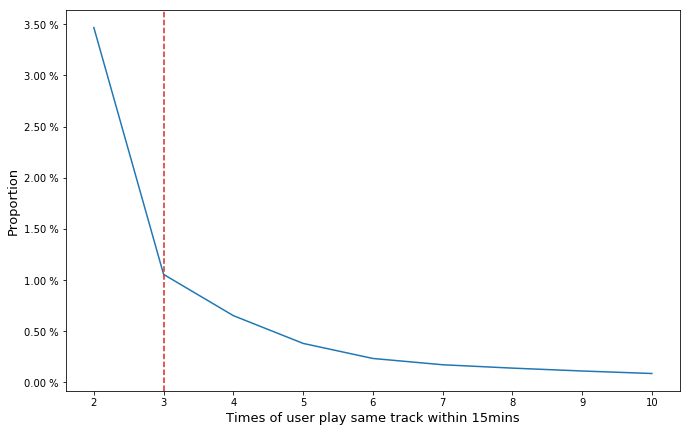

In [418]:
from matplotlib.ticker import FuncFormatter

def dis_percent(x, pos):
    return '%1.2f %%' %(x * 100)

prop = len(play_single)
x = np.arange(2, 11, 1)
y = [len(play_single.loc[play_single>=i])/prop for i in x]


fig, ax = plt.subplots(figsize=(11, 7))
formatter = FuncFormatter(dis_percent)
ax.yaxis.set_major_formatter(formatter)
plt.plot(x, y)
plt.axvline(x=3, color=colors[3], linestyle='dashed')
plt.xlabel('Times of user play same track within 15mins', fontsize=13)
plt.ylabel('Proportion', fontsize=13)

plt.show()

In [377]:
fraud = play_single.loc[play_single>3]
fraud.name = 'cnt'
fraud = fraud.reset_index()
playSingle_userId = fraud['user_id'].unique()

In [403]:
abnormal_user = np.append(abnormal_user, playSingle_userId)

In [378]:
playSingle_userId.shape[0]/streams['user_id'].unique().shape[0]

0.004069906631553747

# Abnomal Behavior 3:  huge amount of play
## Rules :  ueser play exceed 5 times in same period 
describe: there is elbow in below chart, 5 is a turining point 

In [4]:
# Find potentially outlier
# Get timestamp of outlier
time_group = streams.groupby(['timestamp']).size()
outlier = time_group[time_group.diff()/time_group > (time_group.diff()/time_group).std()].index
outlier.tolist()

[Timestamp('2017-09-09 02:00:00'),
 Timestamp('2017-09-09 04:15:00'),
 Timestamp('2017-09-09 05:00:00'),
 Timestamp('2017-09-09 08:00:00'),
 Timestamp('2017-09-09 11:00:00'),
 Timestamp('2017-09-09 14:00:00'),
 Timestamp('2017-09-09 17:00:00'),
 Timestamp('2017-09-09 20:00:00'),
 Timestamp('2017-09-09 23:00:00')]

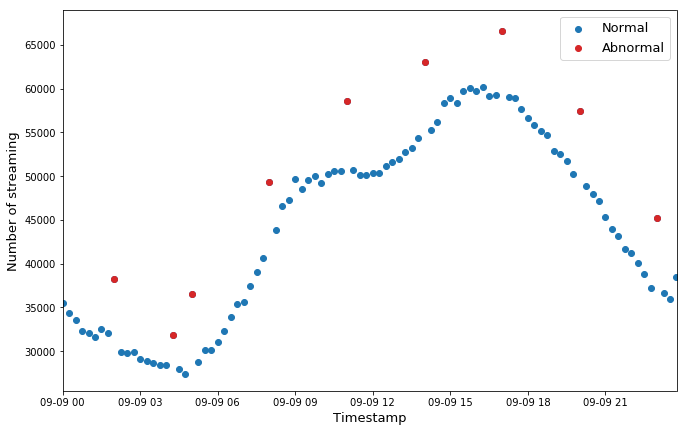

In [5]:
plt.figure(figsize=(11, 7))
plt.scatter(x=time_group.index, y=time_group.values, color=colors[0], label='Normal')
plt.scatter(x=time_group.loc[outlier].index, y=time_group.loc[outlier].values, color=colors[3], label='Abnormal')
plt.xlim(min(time_group.index), max(time_group.index))
plt.xlabel('Timestamp', size=13)
plt.ylabel('Number of streaming', size=13)
plt.legend(prop={'size': 13})

plt.show()

### number of unique user in 15 mins

In [87]:
user_cnt_time = streams.groupby('timestamp')['user_id'].nunique()

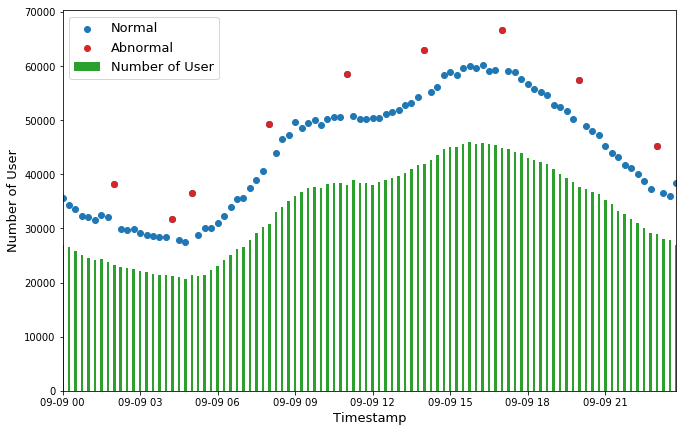

In [421]:
plt.figure(figsize=(11, 7))

plt.scatter(x=time_group.index, y=time_group.values, color=colors[0], label='Normal')
plt.scatter(x=time_group.loc[outlier].index, y=time_group.loc[outlier].values, color=colors[3], label='Abnormal')

plt.bar(user_cnt_time.index, user_cnt_time.values,color=colors[2],width=0.004, label='Number of User')

plt.xlim(min(time_group.index), max(time_group.index))
plt.xlabel('Timestamp', size=13)
plt.ylabel('Number of User', size=13)
plt.legend(prop={'size': 13})

plt.show()

### play times 
point out the outlier of number of listen in 15mins

In [171]:
user_listen_time = streams.groupby(['timestamp','user_id']).size()

play time > 5, the slopes are become shallow

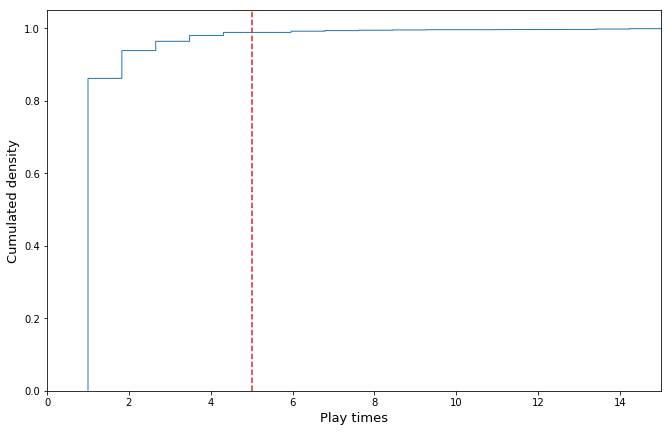

In [302]:
plt.figure(figsize=(11, 7))
plt.xlim(0,15)
plt.hist(user_listen_time,4000,cumulative=True, histtype='step', normed=1)
plt.axvline(x=5, color=colors[3], linestyle='dashed')

plt.xlabel('Play times', size=13)
plt.ylabel('Cumulated density', size=13)
plt.show()

outlier: play times > 5  
count outlier user in each 15mins

In [373]:
# outlier- play time user id
playTime_userId =  user_listen_time[user_listen_time>5].reset_index()['user_id'].unique()

In [405]:
abnormal_user = np.append(abnormal_user, playTime_userId)

In [375]:
playTime_userId.shape[0]/streams['user_id'].unique().shape[0]

0.0073947451441919365

In [259]:
user_time_outlier = playTime_userId.groupby('timestamp').size()

outlier of play times affect the abnormal streams

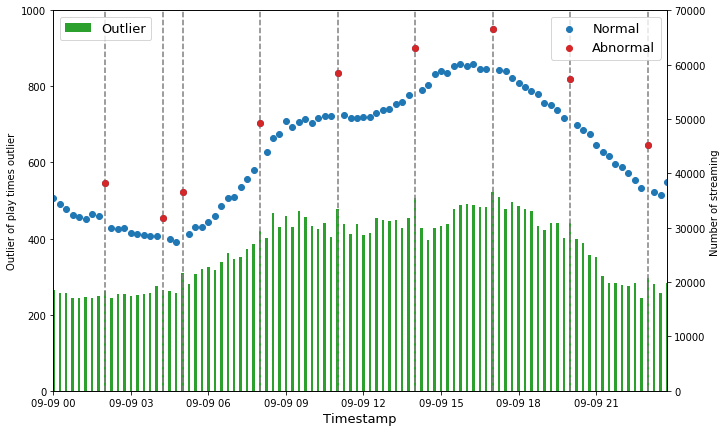

In [309]:
fig, ax1 = plt.subplots(figsize=(11, 7))
ax1.set_xlim(min(time_group.index), max(time_group.index))
ax1.set_ylim(0,1000)
[ax1.axvline(x= i ,color= colors[7], linestyle='dashed') for i in time_group.loc[outlier].index]
ax1.bar(user_time_outlier.index, user_time_outlier.values,color=colors[2],width=0.004, label='Outlier')
ax1.set_ylabel('Outlier of play times outlier')
ax1.set_xlabel('Timestamp', size=13)
ax1.legend(prop={'size': 13})

ax2 = ax1.twinx()
ax2.set_ylim(0,70000)
ax2.scatter(x=time_group.index, y=time_group.values, color=colors[0], label='Normal')
ax2.scatter(x=time_group.loc[outlier].index, y=time_group.loc[outlier].values, color=colors[3], label='Abnormal')
ax2.set_ylabel('Number of streaming ')
ax2.legend(prop={'size': 13})

plt.show()

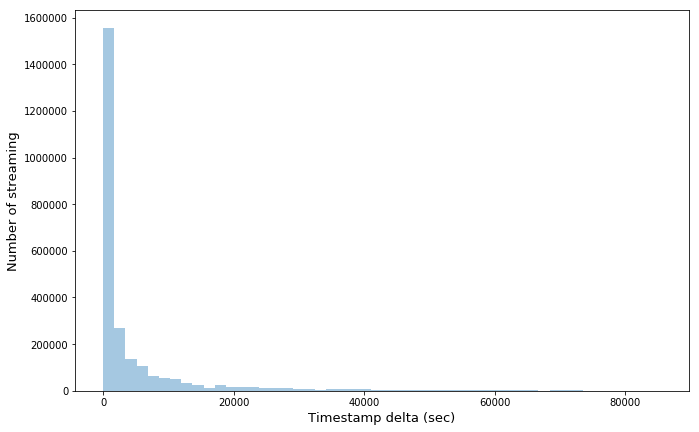

In [158]:
# Plot delta distribution
plt.figure(figsize=(11, 7))
sns.distplot(streams['delta'].dropna(), kde=False)
plt.xlabel('Timestamp delta (sec)', size=13)
plt.ylabel('Number of streaming', size=13)
plt.show()

# Summary

In [409]:
abnormal_user.shape, np.unique(abnormal_user).shape

((39380,), (22052,))

In [410]:
np.unique(abnormal_user).shape[0]/streams['user_id'].unique().shape[0]

0.012335016635379772

In [417]:
streams['user_id'].unique().shape[0]

1787756

In [413]:
pd.Series(abnormal_user).to_csv('/disk/ru/abnormal_user.csv',index=False)

# 6/12 Discussion

## 1. Would it automately segment the big size of release when the duration of release exceed 900 sec?
ex : same track release several time and been released at continuous peiord (like 08:30 and 08:45)

In [31]:
release.loc[(streams['track_id']=='d23e6c7bdef19e7a223a95c6e3ab6177671037fa') & 
            (streams['user_id']=='9a052dec69a62f6ade87ae7fb7ed5ce344c0f047')].head(10)

,device_type,length,os,timestamp,track_id,user_id,delta
1247,mobile,900,iOS,2017-09-09 00:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,NaN
4652,mobile,202,iOS,2017-09-09 00:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1160773,tablet,400,iOS,2017-09-09 08:30:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,30600.0
1180417,tablet,202,iOS,2017-09-09 08:45:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,900.0
1231519,tablet,202,iOS,2017-09-09 09:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1248030,tablet,501,iOS,2017-09-09 09:00:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1275677,tablet,397,iOS,2017-09-09 09:15:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1513651,mobile,345,iOS,2017-09-09 10:15:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1513697,mobile,213,iOS,2017-09-09 10:15:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,0.0
1521253,mobile,202,iOS,2017-09-09 10:30:00,d23e6c7bdef19e7a223a95c6e3ab6177671037fa,9a052dec69a62f6ade87ae7fb7ed5ce344c0f047,900.0


## 2. Is it a normal scenario that same tack been released by different users?
track_id = '2318538f5412b3e87cf335fb667c0e7f121ae830'   
released by 98 unique users

In [32]:
track_cnt = streams['track_id'].value_counts()

In [33]:
track_cnt.describe()

count     83426.000000
mean         51.705487
std        1251.849138
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max      232564.000000
Name: track_id, dtype: float64

In [35]:
track_top_index = track_cnt[track_cnt>10].index
track_top = streams.loc[streams['track_id'].isin(track_top_index)]

In [38]:
streams[streams['track_id']=='2318538f5412b3e87cf335fb667c0e7f121ae830']['user_id'].unique().shape

(98,)

In [40]:
streams[streams['track_id']=='2318538f5412b3e87cf335fb667c0e7f121ae830']['user_id'].unique()[:10]

array(['bab3607bf601e7e681012f206b62b4b39ee7023c',
       'ced586ba20b5c939afce663869ea6d2dbe100ae3',
       'd64bc4d547fa77a1df5490eeea205e2b96448744',
       '46ba44758a656c71af6fa8d61a1d82a8ebc24320',
       '435586b2ccecb215a907fce07b15f5959fa28fe0',
       '56e2506c1270e838cd401d7aa117dee8d7170514',
       '2f35b4e14a2eaddb04c30a5adf19010856387e0e',
       'b6e97cda7559fb309836f9d3142c8d8f97a3d4d5',
       '79311a85288b7f84dafab916a2975e2674a46a6f',
       '095d42c87e01748c1fecb23723c887ea6d8bc793'], dtype=object)